In [1]:
# --- 1. SETUP AND IMPORTS ---
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


In [2]:
# --- 2. DATA LOADING ---
try:
    data = pd.read_csv('water_potability.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'water_potability.csv' not found.")
    print("Please download the dataset from Kaggle and place it in the same directory.")
    exit()

# --- 3. TASK 1: PREPROCESSING TECHNIQUES & EDA ---
# This entire section is identical to the previous script to ensure
# we are training on the exact same, prepared data.

Dataset loaded successfully.



--- EDA for Technique 1: Missing Values ---


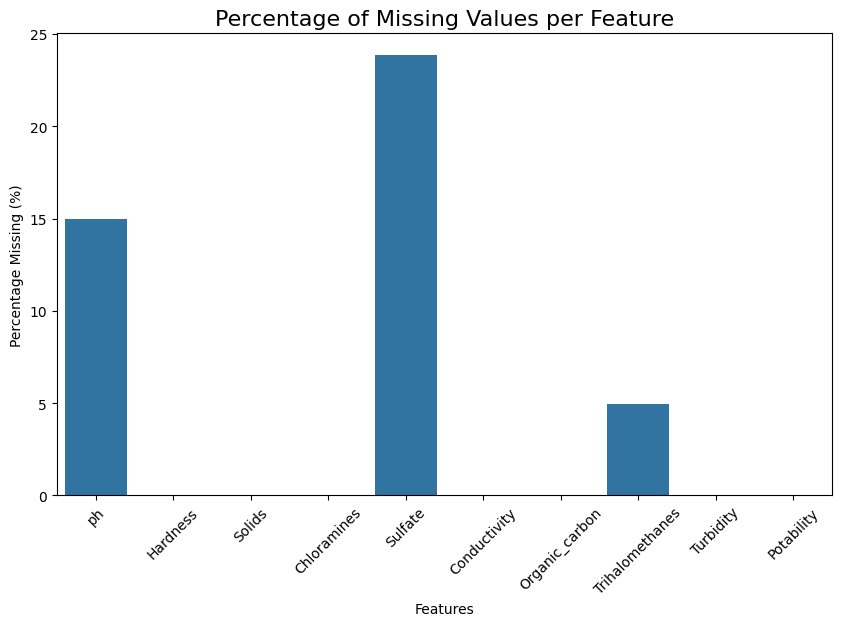

EDA Conclusion: 'ph', 'Sulfate', and 'Trihalomethanes' have significant missing data.
Preprocessing Step: We will use KNNImputer to fill these, as it's more accurate than a simple mean.


In [3]:
# --------------------------------------------------------------------------
# Technique 1 (Member 1): Handling Missing Values
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 1: Missing Values ---")
missing_percent = (data.isnull().sum() / len(data)) * 100
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.index, y=missing_percent.values)
plt.title('Percentage of Missing Values per Feature', fontsize=16)
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.show()

print("EDA Conclusion: 'ph', 'Sulfate', and 'Trihalomethanes' have significant missing data.")
print("Preprocessing Step: We will use KNNImputer to fill these, as it's more accurate than a simple mean.")


--- EDA for Technique 2: Class Imbalance ---


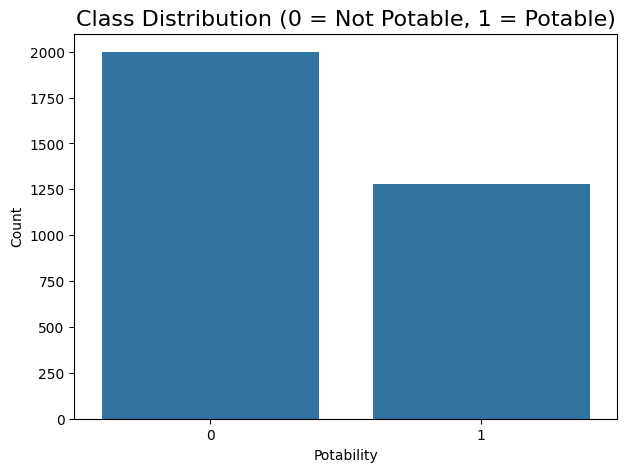

Distribution:
Potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64
EDA Conclusion: The dataset is imbalanced. There are more 'Not Potable' (0) samples.
Preprocessing Step: We will use SMOTE (Synthetic Minority Over-sampling Technique) on the training data to create a balanced dataset for the model to learn from.


In [4]:
# --------------------------------------------------------------------------
# Technique 2 (Member 2): Handling Class Imbalance
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 2: Class Imbalance ---")
plt.figure(figsize=(7, 5))
sns.countplot(x='Potability', data=data)
plt.title('Class Distribution (0 = Not Potable, 1 = Potable)', fontsize=16)
plt.xlabel('Potability')
plt.ylabel('Count')
plt.show()

print(f"Distribution:\n{data['Potability'].value_counts(normalize=True)}")
print("EDA Conclusion: The dataset is imbalanced. There are more 'Not Potable' (0) samples.")
print("Preprocessing Step: We will use SMOTE (Synthetic Minority Over-sampling Technique) on the training data to create a balanced dataset for the model to learn from.")


--- EDA for Technique 3: Feature Distributions (Outliers) ---


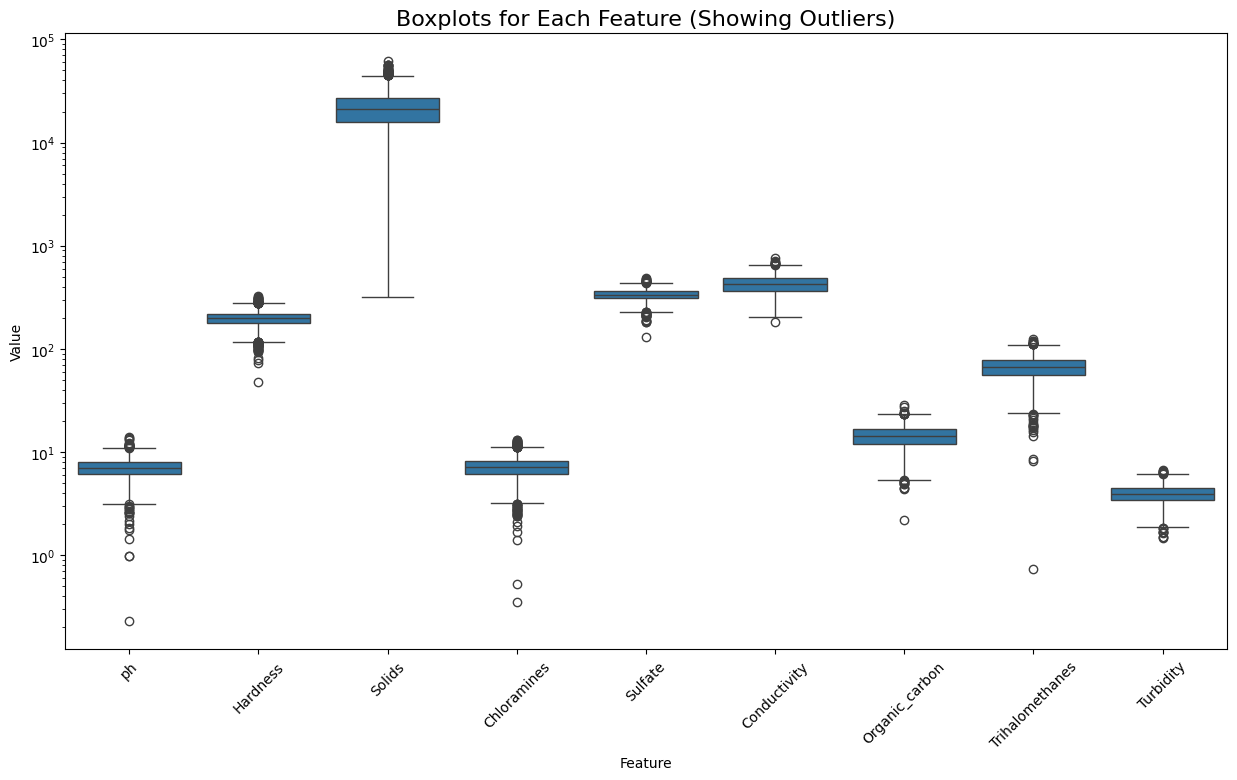

EDA Conclusion: Features have vastly different scales and ranges (e.g., 'Solids' is in 10,000s, 'pH' is 0-14).
Preprocessing Step: Feature Scaling is mandatory for neural networks.


In [5]:
# --------------------------------------------------------------------------
# Technique 3 (Member 3): Exploring Feature Distributions & Outliers
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 3: Feature Distributions (Outliers) ---")
data_melted = pd.melt(data, id_vars=['Potability'], var_name='Feature', value_name='Value')
plt.figure(figsize=(15, 8))
sns.boxplot(x='Feature', y='Value', data=data_melted, showfliers=True)
plt.title('Boxplots for Each Feature (Showing Outliers)', fontsize=16)
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

print("EDA Conclusion: Features have vastly different scales and ranges (e.g., 'Solids' is in 10,000s, 'pH' is 0-14).")
print("Preprocessing Step: Feature Scaling is mandatory for neural networks.")


--- EDA for Technique 4: Feature Scaling (Before/After) ---


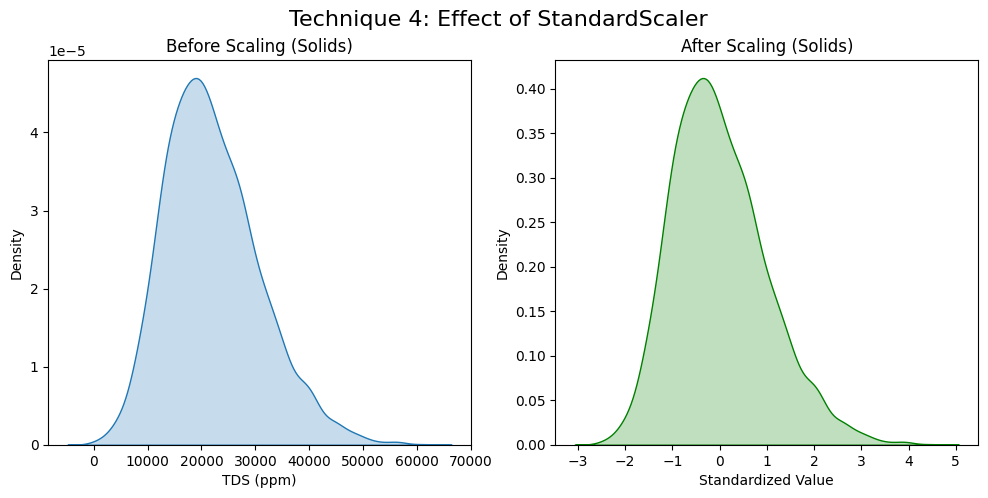

EDA Conclusion: Scaling centers the data around 0 and squashes it to a standard range.
Preprocessing Step: We will apply StandardScaler to all 9 features after splitting the data.


In [6]:
# --------------------------------------------------------------------------
# Technique 4 (Member 4): Feature Scaling
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 4: Feature Scaling (Before/After) ---")
scaler_demo = StandardScaler()
solids_data = data[['Solids']].dropna()
solids_scaled = scaler_demo.fit_transform(solids_data)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(solids_data['Solids'], fill=True)
plt.title('Before Scaling (Solids)')
plt.xlabel('TDS (ppm)')

plt.subplot(1, 2, 2)
sns.kdeplot(solids_scaled.flatten(), fill=True, color='green')
plt.title('After Scaling (Solids)')
plt.xlabel('Standardized Value')
plt.suptitle('Technique 4: Effect of StandardScaler', fontsize=16)
plt.show()

print("EDA Conclusion: Scaling centers the data around 0 and squashes it to a standard range.")
print("Preprocessing Step: We will apply StandardScaler to all 9 features after splitting the data.")


--- EDA for Technique 5: Feature Correlation ---


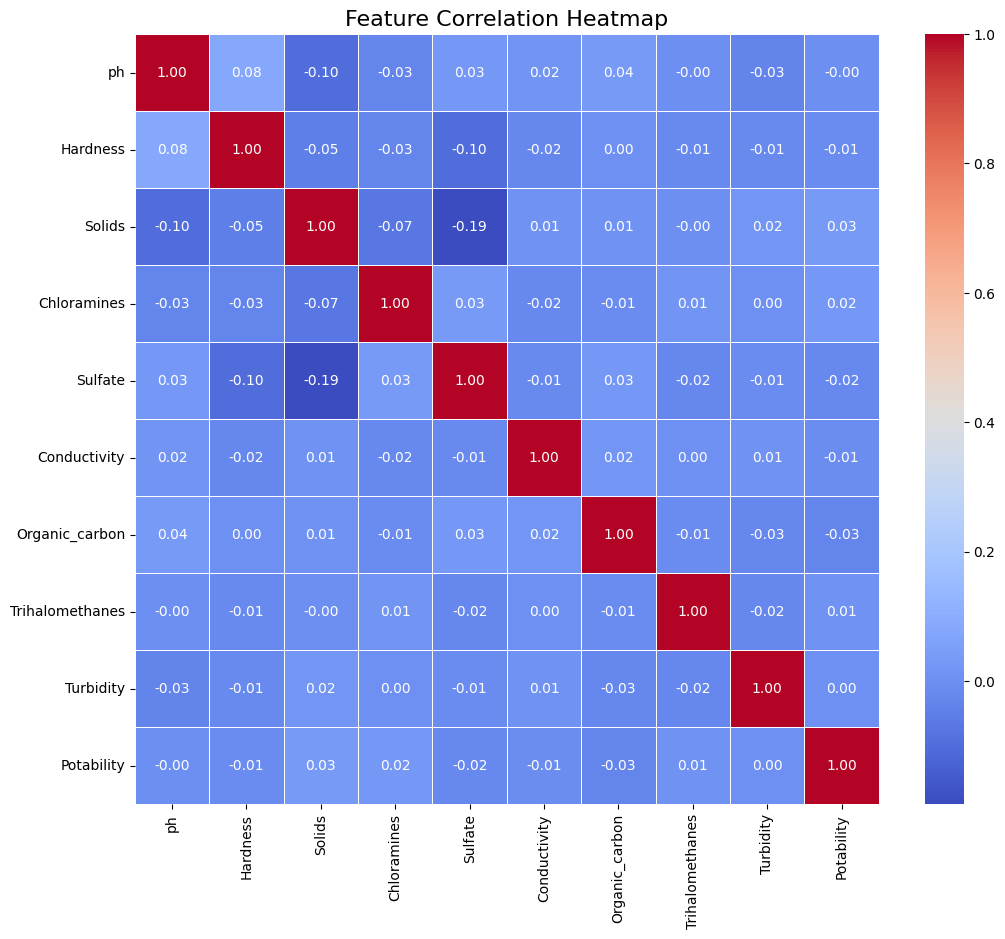

EDA Conclusion: No features are extremely highly correlated (e.g., > 0.9 or < -0.9).
This suggests that all 9 features provide unique information and should be kept for the model.


In [7]:
# --------------------------------------------------------------------------
# Technique 5 (Member 5): Correlation Analysis
# --------------------------------------------------------------------------
print("\n--- EDA for Technique 5: Feature Correlation ---")
imputer_demo = KNNImputer(n_neighbors=5)
data_imputed_demo = pd.DataFrame(imputer_demo.fit_transform(data), columns=data.columns)
corr = data_imputed_demo.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.show()

print("EDA Conclusion: No features are extremely highly correlated (e.g., > 0.9 or < -0.9).")
print("This suggests that all 9 features provide unique information and should be kept for the model.")

In [8]:
# --------------------------------------------------------------------------
# Final Combined Preprocessing Pipeline (The "How-To")
# --------------------------------------------------------------------------
print("\n--- Final Preprocessing Pipeline (Code) ---")
print("Combining all techniques to prepare data for the model...")

# 1. Impute Missing Values
print("Step 1: Imputing missing values with KNNImputer...")
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# 2. Feature / Target Split
print("Step 2: Separating features (X) and target (y)...")
X = data_imputed.drop('Potability', axis=1)
y = data_imputed['Potability']

# 3. Data Splitting (Train/Test)
print("Step 3: Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Original training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# 4. Handle Class Imbalance (SMOTE)
print("Step 4: Balancing training data with SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled training samples: {X_train_resampled.shape[0]}")

# 5. Feature Scaling
print("Step 5: Applying StandardScaler...")
scaler = StandardScaler()
# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train_resampled)
# Apply the same scaler to the test data
X_test_scaled = scaler.transform(X_test)

print("\n✅ Final data pipelines are built and ready for model training.")
print("The 'scaler' object is saved to apply to new user input in the app.")
print("(This scaler will be saved as 'scaler_ALT.joblib' to match this model)")


--- Final Preprocessing Pipeline (Code) ---
Combining all techniques to prepare data for the model...
Step 1: Imputing missing values with KNNImputer...
Step 2: Separating features (X) and target (y)...
Step 3: Splitting data into training and test sets...
Original training samples: 2620, Test samples: 656
Step 4: Balancing training data with SMOTE...
Resampled training samples: 3196
Step 5: Applying StandardScaler...

✅ Final data pipelines are built and ready for model training.
The 'scaler' object is saved to apply to new user input in the app.
(This scaler will be saved as 'scaler_ALT.joblib' to match this model)


In [9]:
# --- 4. TASK 2: ALGORITHM SELECTION, IMPLEMENTATION & HYPERPARAMETER TUNING ---

"""
### Task 2.1: Algorithm Selection
We will use a DNN, but with DIFFERENT hyperparameters to compare results.
"""

# --- Task 2.2: Model Implementation ---
def build_model(input_shape):

    # *** HYPERPARAMETER CHANGE ***
    # Original model was (64 -> 128 -> 64) with 0.3 Dropout
    # This is a smaller, simpler model with less aggressive Dropout.
    model = Sequential([
        Dense(32, activation='relu', input_shape=[input_shape]),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid') # Output layer remains the same
    ])
    return model

model = build_model(X_train_scaled.shape[1])
model.summary() # This summary will look different from the first model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
"""
### Task 2.3: Hyperparameter Tuning Strategy
We will use a much FASTER learning rate and LESS patient callbacks
to demonstrate how this affects training.
"""

# --- Model Training ---
print("\n--- Model Training (Alternative Hyperparameters) ---")

# *** HYPERPARAMETER CHANGE ***
# Original learning_rate was 0.001
# 0.01 is a very high/fast learning rate and may be unstable
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# *** HYPERPARAMETER CHANGE ***
# Original patience was 20 (EarlyStopping) and 10 (ReduceLROnPlateau)
# This model is much less patient and will stop/adjust sooner.
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
]

# Train on the same RESAMPLED and SCALED data
history = model.fit(
    X_train_scaled,
    y_train_resampled,
    epochs=200,
    validation_data=(X_test_scaled, y_test),
    callbacks=callbacks,
    batch_size=32
)


--- Model Training (Alternative Hyperparameters) ---
Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5643 - loss: 0.6932 - val_accuracy: 0.5930 - val_loss: 0.6544 - learning_rate: 0.0100
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6185 - loss: 0.6477 - val_accuracy: 0.6418 - val_loss: 0.6286 - learning_rate: 0.0100
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6230 - loss: 0.6389 - val_accuracy: 0.6646 - val_loss: 0.6155 - learning_rate: 0.0100
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6437 - loss: 0.6320 - val_accuracy: 0.5777 - val_loss: 0.6521 - learning_rate: 0.0100
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6416 - loss: 0.6290 - val_accuracy: 0.6006 - val_loss: 0.6487 - learning_rate: 0.0100
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6554 - loss: 0.6269 - val_accuracy: 0.5869 - val_loss: 0.6663 - learning_rate: 0.0100
Epoch 7/200
100/100 ━━━━━━━━


--- Final Model Evaluation (Alternative Model) ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6579 - loss: 0.6226

Final Test Loss: 0.6155
Final Test Accuracy: 66.46%
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Detailed Classification Report (Alternative Model) ---
                 precision    recall  f1-score   support

Not Potable (0)       0.71      0.76      0.73       400
    Potable (1)       0.58      0.52      0.55       256

       accuracy                           0.66       656
      macro avg       0.64      0.64      0.64       656
   weighted avg       0.66      0.66      0.66       656


--- CRITICAL METRIC ANALYSIS (Alternative Model) ---
Precision (Class 1 - Potable): 57.76%
Total DANGEROUS Predictions (False Positives): 98
-----------------------------------

>>> COMPARE THIS ACCURACY AND FALSE POSITIVE COUNT TO THE FIRST MODEL <<<


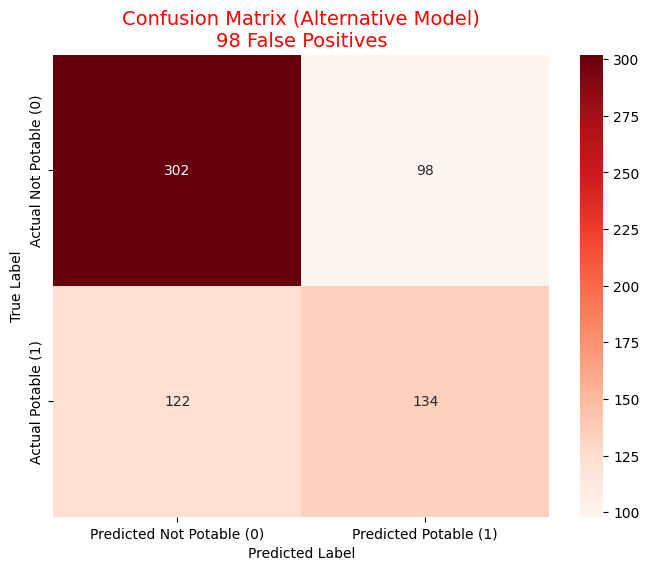

In [11]:
# --- 5. TASK 3: EVALUATION METRICS ---
"""
### Task 3.1: Evaluation Metrics
We will evaluate this new model just as we did the first,
focusing on the False Positive count.
"""
print("\n--- Final Model Evaluation (Alternative Model) ---")
final_loss, final_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"\nFinal Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")

y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# --- CRITICAL EVALUATION ---
cm = confusion_matrix(y_test, y_pred)
precision_class_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
false_positives = cm[0][1]

print("\n--- Detailed Classification Report (Alternative Model) ---")
print(classification_report(y_test, y_pred, target_names=['Not Potable (0)', 'Potable (1)'], zero_division=0))

print("\n--- CRITICAL METRIC ANALYSIS (Alternative Model) ---")
print(f"Precision (Class 1 - Potable): {precision_class_1 * 100:.2f}%")
print(f"Total DANGEROUS Predictions (False Positives): {false_positives}")
print("-----------------------------------")
print("\n>>> COMPARE THIS ACCURACY AND FALSE POSITIVE COUNT TO THE FIRST MODEL <<<")


plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, fmt='d', cmap='Reds',
    xticklabels=['Predicted Not Potable (0)', 'Predicted Potable (1)'],
    yticklabels=['Actual Not Potable (0)', 'Actual Potable (1)']
)
plt.title(f'Confusion Matrix (Alternative Model)\n{false_positives} False Positives', fontsize=14, color='red')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [12]:
# --- 6. TASK 4: ETHICAL AND BIAS ANALYSIS ---
"""
### Task 4.1: Ethical and Bias Analysis
The ethical analysis remains the same, as the core task and its risks
have not changed, even if the model's performance has. The risk of
False Positives is the primary concern.
"""

"\n### Task 4.1: Ethical and Bias Analysis\nThe ethical analysis remains the same, as the core task and its risks\nhave not changed, even if the model's performance has. The risk of\nFalse Positives is the primary concern.\n"

In [13]:
# --- 7. SAVE THE FINAL MODEL AND SCALER ---
# *** FILENAME CHANGE ***
# Save this new model and its scaler with different names
model.save('water_quality_model_ALT.h5')
joblib.dump(scaler, 'scaler_ALT.joblib')

print("\n✅ Alternative model saved as 'water_quality_model_ALT.h5'")
print("✅ Alternative scaler saved as 'scaler_ALT.joblib'")
print("\nProject setup complete. You now have two different models to compare.")


✅ Alternative model saved as 'water_quality_model_ALT.h5'
✅ Alternative scaler saved as 'scaler_ALT.joblib'

Project setup complete. You now have two different models to compare.
